# COMP5318: Assignment 1 - Image Classification

Author: Jesse Serina Narvasa<br>
SID: 500525438 <br>
Unikey: jnar3156


In order to consider classification performance, the specifications of the machine used to run this notebook is provided as follows:

Dell XPS 13 9350<br>
Intel Core i7-6560U 2.20GHz<br>
8GB RAM<br>
Integrated graphics<br>
Windows 10 Pro 19041.572<br>
Running Python 3.6.4

In [11]:
# Library imports

import time
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [12]:
# Loading our training data

with h5py.File('./Input/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])
    
# Loading our testing data

with h5py.File('./Input/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

In [13]:
# Verifying our loaded training data
print(data_train.shape, label_train.shape)

# Verifying our loaded testing data
print(data_test.shape, label_test.shape)

(30000, 784) (30000,)
(5000, 784) (2000,)


In [14]:
# Class mappings
class_mappings = {
    0: 'T-shirt/Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

### Utility Functions

In [15]:
def calc_top1_accuracy(predicted, actual):
    '''
    Calculates the top-1 accuracy metric, given the predicted classes against the actual classes
    INPUT: 1D array of predicted results,
        1D array of actual results
    OUTPUT: percentage in decimal format of accuracy    
    '''
    correct = 0
    for n in range(actual.shape[0]):
        if predicted[n] == actual[n]:
            correct += 1
        
    return correct/actual.shape[0]

In [16]:
def output_prediction(predictions):
    '''
    Generates the output file for the predictions
    INPUT: 1D array of predicted results
    OUTPUT: prediction file of .h5 format
    '''
    with h5py.File('./Output/predicted_labels.h5','w') as H:
        H.create_dataset('Output',data=predictions)

In [17]:
def train_validation_split(train_ratio, data_train, label_train):
    '''
    Splits the dataset for X and y into training and validation datasets based on the given ratio
    INPUT: train split ratio, training dataset, label dataset
    OUTPUT: training data and label numpy arrays, validation data and label numpy arrays
    '''
    # obtain the row number where we conduct the split
    row_split = int(train_ratio * data_train.shape[0])
    
    # shuffle our matrices
    shuffled_idx = np.arange(data_train.shape[0])
    np.random.shuffle(shuffled_idx)
    data_train = data_train[shuffled_idx]
    label_train = label_train[shuffled_idx]
        
    # create the train/test split
    split_data_train = data_train[:row_split, :]
    split_label_train = label_train[:row_split]
    split_data_validation = data_train[row_split:, :]
    split_label_validation = label_train[row_split:]
    
    return split_data_train, split_label_train, split_data_validation, split_label_validation

### Pre-processing

#### PCA

In [18]:
def apply_pca(data_train, data_test, n_components=45):
    '''
    Apply PCA on the given dataset
    INPUT: 2D or 3D array dataset for data_train and data_test,
        INT n_components for the number of components to be retained, or set to STR 'dynamic' to count eigenvalues > 1
    OUTPUT: 2D array of dataset reduced to n dimensions
    '''
    if len(data_train.shape) != 2:
        data_train = data_train.reshape((data_train.shape[0], data_train.shape[1]**2))
    if len(data_test.shape) != 2:
        data_test = data_test.reshape((data_test.shape[0], data_test.shape[1]**2))
    
    # Need to get the mean of each feature, for mean normalisation/centreing
    data_train_mean = data_train.mean(axis=0)
    data_test_mean = data_test.mean(axis=0)
    # Feature means should now be zero, or approx. close to zero - and hence centred
    data_train_centred = np.subtract(data_train, data_train_mean)
    data_test_centred = np.subtract(data_test, data_test_mean)
    
    # Checking the following, we can see that the max and min value of the entire matrix is 0 and 1
    # hence scaling is not required
    '''
    print(data_train.min())
    print(data_train.max())
    print(data_test.min())
    print(data_test.max())
    '''
    
    covariance_matrix = (data_train_centred.T).dot(data_train_centred)
    l, V = np.linalg.eig(covariance_matrix)
    
    sorted_lambda_index =  l.argsort()[::-1] # sorting our lambda values from largest to smallest
    l = l[sorted_lambda_index] # sort eigvals from largest to smallest
    
    if n_components == 'dynamic':
        # to dynamically set what our n_components will be, we consider that PCA is used where we obtain the
        # orthonormal eigenvectors which obtain the most variance.  Here, we will use the sorted eigenvals
        # to ensure that we include all eigenvectors which explain 99.99% of the variance in our data
        # the dimensions beyond that are discarded, as being insignificant
        l_squared = np.square(l)
        l_squared_sum = l_squared.sum()
        running_squared_sum = 0
        n_components = 0
        for idx, eigval_sqrd in enumerate(l_squared):
            running_squared_sum += eigval_sqrd
            if (running_squared_sum/l_squared_sum) > 0.9999:
                n_components = idx + 1
                break
        print(f'Number of components retained is: {n_components}')
        
    V_n = V[:,sorted_lambda_index[:n_components]]
    
    # Do the projection of the image matrix against our orthogonal eigenvector matrix reduced to n columns
    pca_data_train = data_train_centred.dot(V_n)
    pca_data_test = data_test_centred.dot(V_n)
    
    return (pca_data_train, pca_data_test)

### Classification Algorithms

#### k-Nearest Neighbours

In [19]:
def knn(data_train, label_train, data_test, K=3):
    '''
    k-Nearest Neighbour classifier
    INPUT: Matrix of training dataset (data_train),
        1D array of label of training dataset (label_train),
        matrix dataset to be predicted (data_test),
        (optional) K number of nearest neighbours
    OUTPUT: 1D array of predicted results with the same length as data_test.shape[0]
    '''
        
    # Instantiating our empty array for predicted values
    pred_test = np.zeros(data_test.shape[0])
    
    for image_num in range(data_test.shape[0]):
        # Calculating the distance difference between the test subject and all our training points
        # Basically the same as getting the norm of (data_train - data_test[image_num]) for each instance
        sum_sqrd_distances = np.sqrt((np.square(np.subtract(data_train, data_test[image_num]))).sum(axis=1))
    
        # Getting the k nearest neighbours
        k_nearest_neighbours = (np.argsort(sum_sqrd_distances))[:K]
    
        classes_dict = {}

        # Using weighted distance, instead of simply using count
        for neighbour_idx in k_nearest_neighbours:
            classification = label_train[neighbour_idx]
            if classification in classes_dict:
                classes_dict[classification] += 1/(sum_sqrd_distances[neighbour_idx]**2)
            else:
                classes_dict[classification] = 1/(sum_sqrd_distances[neighbour_idx]**2)
            
        pred_class = None
        for key in classes_dict:
            if pred_class == None:
                pred_class = key
                continue

            if classes_dict[key] > classes_dict[pred_class]:
                pred_class = key
                
        pred_test[image_num] = pred_class
            
    return pred_test

#### Gaussian Naive Bayes

In [20]:
def gaussian_naive_bayes(data_train, label_train, data_test):
    '''
    Gaussian Naive Bayes classifier
    INPUT: Matrix training dataset (data_train),
        1D array of label on training dataset (label_train),
        matrix of test dataset (data_test)
    OUTPUT: 1D array of predicted classes on test dataset
    '''

    # Obtaining the different classes that we have present in our training data and getting index positions of each one
    class_indices = {}
    for idx, image_class in enumerate(label_train):
        if image_class not in class_indices:
            class_indices[image_class] = [idx]
            continue
        else:
            class_indices[image_class].append(idx)
        
    class_mean = {}
    class_var = {}

    # Obtain the mean and std dev for each class of our training data
    for class_index in class_indices:
        class_mean[class_index] = data_train[class_indices[class_index], :].mean(axis=0)
        class_var[class_index] = data_train[class_indices[class_index], :].var(axis=0)

    pred_test = np.zeros(data_test.shape[0])

    for image_num in range(data_test.shape[0]):
        # In order to find the length of pred_class_scores, we need to get the max value of the keys
        # with the assumption that each number up to the max will be a class
        # we do this instead of length because our training data may not have an entry for a class, hence, it'll
        # result in out of range if a data exists for one higher
        pred_class_scores = np.zeros(max(class_indices, key=int)+1)
        
        for class_index in class_indices:
            
            # Calculating the logged prior probability
            class_prob = np.log(len(class_indices[class_index])/data_train.shape[0])

            # Calculating the sum of the logged conditional probability
            likelihood_array = st.norm.logpdf(x=data_test[image_num], loc=class_mean[class_index], scale=np.sqrt(class_var[class_index]))
            class_prob = class_prob + np.nansum(likelihood_array) # we use nansum to avoid nan likelihoods, because these are obtained from points with zero variance

            # Storing the result in our results array, so we can keep track of which class has the highest
            pred_class_scores[class_index] = class_prob

        # Class with the highest prob is the predicted class for the image, which is stored in our final pred_test array
        pred_test[image_num] = np.nanargmax(pred_class_scores)
        
    return pred_test

#### Multinomial Logistic Regression

In [21]:
def calc_logistic_loss(weights, X, y, LAMBDA):
    '''
    Provides the gradient and the current loss, used during the logistic gradient descent process
    for finding the optimal weights
    INPUT: vector weights, training dataset (X), labels of training dataset (y), regularisation term (LAMBDA)
    OUTPUT: gradient (vector), current loss (scalar)
    '''
    
    # Basically the vector of inputs for our sigmoid function
    z = X.dot(weights)
    
    # Now placing it inside our sigmoid function.  This will produce vector of probabilities of size N
    prob = 1/(1 + np.exp(-z))
    
    # getting the gradient at the current point
    grad_loss = X.T.dot((prob - y)) - (LAMBDA * weights)
    
    # getting the current loss, since we want to do minimisation problem (not maximisation)
    curr_loss = -((np.log(prob)).T.dot(y) + (np.log(1-prob)).T.dot(1-y)) + (LAMBDA/2 * (weights.T.dot(weights)))
    
    return grad_loss, curr_loss[0]


def multiclass_logistic_regression(data_train, label_train, data_test, LEARNING_RATE, LAMBDA, MAX_ITER, plot_it=False):
    '''
    Function used for multinomial logistic regression - classification problem of multiple classes
    INPUT: training data, labels of training data, test/validation dataset, learning rate, regularisation term, iterations
    OUTPUT: predictions for the given test/validation dataset (vector)
    '''

    # getting the unique labels that we have in dataset
    # using arange in this case, in case we are provided a dataset where an instance of a class is not provided
    # i.e. max(label_train)+1 != len(label_train)
    labels = np.arange(np.max(label_train))

    # instantiating a blank matrix to store our optimal weights - shape is D x number of labels
    optimal_weights = np.zeros((data_train.shape[1], len(labels)))

    for label in labels:
        # the objective of this part is to classify the current class as 1, and the others as 0
        X0 = data_train[np.where(label_train!=label)[0], :]
        X1 = data_train[np.where(label_train==label)[0], :]
        y0 = np.zeros(X0.shape[0])
        y1 = np.ones(X1.shape[0])

        # we then re-join the two matrices (0s and 1s) for X and y
        X = np.concatenate((X0, X1), axis=0)
        y = np.concatenate((y0, y1))[:, np.newaxis]

        N, D = X.shape
    
        # select a random starting point for our gradient descent
        weights = np.random.random(D)[:, np.newaxis]
    
        # used to keep track loss for each iteration
        loss_array = []

        # gradient descent algorithm for logistic regression
        for _ in range(MAX_ITER):
            dloss, current_loss = calc_logistic_loss(weights, X, y, LAMBDA)
            # updating our weights
            weights = weights - (LEARNING_RATE * (dloss / N))

            loss_array.append(current_loss)

        if plot_it:
            plt.plot(list(range(MAX_ITER)), loss_array)
            plt.show()

        # Storing the optimal weight we just found for the given label/class
        optimal_weights[:, label] = np.squeeze(weights)
        
    # Using our matrix of optimal weights (for each class),
    # getting the probability for each class with our test/validation data
    # the prediction is based on the highest probability (the index will be the class)
    instance_prob_per_class = data_test.dot(optimal_weights)
    predictions = np.argmax(instance_prob_per_class, axis=1)
        
    return predictions

### Hyperparameter Optimisation

#### k-Nearest Neighbours

Checking the result of running kNN with and without PCA side by side with the same K value, and seeing performance and accuracy difference.

In [16]:
split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)

# k-Nearest Neighbours Classifier using raw data as input
start = time.time()
knn_results = knn(split_data_train, split_label_train, split_data_validation, K=5)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(knn_results, split_label_validation)
print(f"Accuracy result for kNN (raw) is: {accuracy}")
print()

# k-Nearest Neighbours Classifier with PCA
start = time.time()
pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components='dynamic')
knn_pca_results = knn(pca_data_train, split_label_train, pca_data_test, K=5)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(knn_pca_results, split_label_validation)
print(f"Accuracy result for kNN (PCA) is: {accuracy}")
print()

Time taken is 829.9648599624634 seconds
Accuracy result for kNN (raw) is: 0.8453333333333334

Number of components retained is: 145
Time taken is 160.02024269104004 seconds
Accuracy result for kNN (PCA) is: 0.8538888888888889



Running hyperparameter optimisation on kNN with PCA since it's superior to kNN without PCA.  In this section, we will be using cross-validation holdout method (shuffle, split, train and validate are done n times, then averaged)

In [18]:
# Finding the best value of K (PCA)

N_RUNS = 1

for K in range(3,48, 3):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components='dynamic')
        knn_pca_results = knn(pca_data_train, split_label_train, pca_data_test, K=K)
        accuracy = calc_top1_accuracy(knn_pca_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for K Nearest Neighbours with K={K} is {(sum(accuracy_results))/N_RUNS}')

Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=3 is 0.8536666666666667
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=6 is 0.8507777777777777
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=9 is 0.8544444444444445
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=12 is 0.8462222222222222
Number of components retained is: 145
Average accuracy result for K Nearest Neighbours with K=15 is 0.8516666666666667
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=18 is 0.8462222222222222
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=21 is 0.8508888888888889
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=24 is 0.8457777777777777
Number of components retained is: 144
Average accur

In [19]:
# Finding the best value of K (PCA)

N_RUNS = 2

for K in range(3,12, 1):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components='dynamic')
        knn_pca_results = knn(pca_data_train, split_label_train, pca_data_test, K=K)
        accuracy = calc_top1_accuracy(knn_pca_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for K Nearest Neighbours with K={K} is {(sum(accuracy_results))/N_RUNS}')

Number of components retained is: 144
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=3 is 0.848111111111111
Number of components retained is: 145
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=4 is 0.8491666666666666
Number of components retained is: 144
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=5 is 0.855
Number of components retained is: 144
Number of components retained is: 145
Average accuracy result for K Nearest Neighbours with K=6 is 0.8538888888888889
Number of components retained is: 145
Number of components retained is: 145
Average accuracy result for K Nearest Neighbours with K=7 is 0.8573333333333333
Number of components retained is: 145
Number of components retained is: 144
Average accuracy result for K Nearest Neighbours with K=8 is 0.8500555555555556
Number of components retained is: 145
Number of components retained is: 145
Av

Running kNN with the best hyperparameter found, against test data

In [20]:
start = time.time()
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components='dynamic')
knn_pca_results = knn(pca_data_train, label_train, pca_data_test, K=7)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(knn_pca_results, label_test)
print(f"Accuracy result for kNN (PCA) is: {accuracy}")

Number of components retained is: 145
Time taken is 137.1469955444336 seconds
Accuracy result for kNN (PCA) is: 0.8365


#### Gaussian Naive Bayes

Checking the result of running Gaussian Naive Bayes classifier with and without PCA side-by-side, and seeing performance and accuracy difference.

In [21]:
split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)

# Gaussian Naive Bayes using raw data as input
start = time.time()
nb_results = gaussian_naive_bayes(split_data_train, split_label_train, split_data_validation)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(nb_results, split_label_validation)
print(f"Accuracy result for NB (raw) is: {accuracy}")
print()


# Gaussian Naive Bayes applied on principal components of dataset
start = time.time()
pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components='dynamic')
nb_pca_results = gaussian_naive_bayes(pca_data_train, split_label_train, pca_data_test)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(nb_pca_results, split_label_validation)        
print(f"Accuracy result for NB (PCA) is: {accuracy}")
print()

c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1782: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:1782: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


Time taken is 30.18200421333313 seconds
Accuracy result for NB (raw) is: 0.6805555555555556

Number of components retained is: 144
Time taken is 24.82900333404541 seconds
Accuracy result for NB (PCA) is: 0.7597777777777778



Running Gaussian Naive Bayes with PCA applied against the test dataset

In [22]:
# Gaussian Naive Bayes applied on principal components of dataset
start = time.time()
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components='dynamic')
nb_pca_results = gaussian_naive_bayes(pca_data_train, label_train, pca_data_test)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(nb_pca_results, label_test)        
print(f"Accuracy result for NB (PCA) is: {accuracy}")
print()

Number of components retained is: 145
Time taken is 16.858540534973145 seconds
Accuracy result for NB (PCA) is: 0.7405



#### Multinomial Logistic Regression

Initial run of the algorithm, and checking the performance of the gradient descent.  Hence we turn on plotting for this instance and make sure that we have converged and are not diverging, or having indication that our learning rate is too high

c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


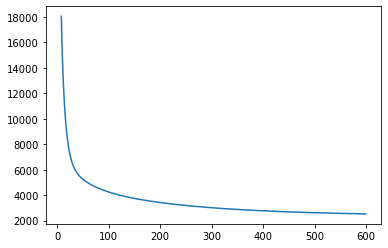

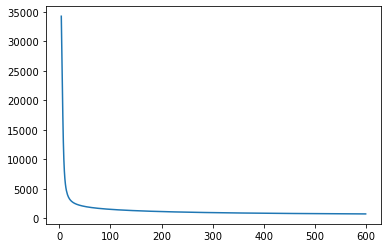

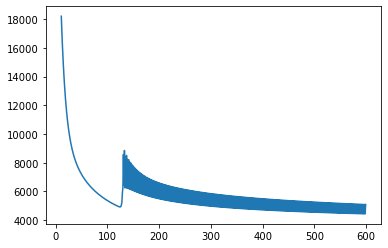

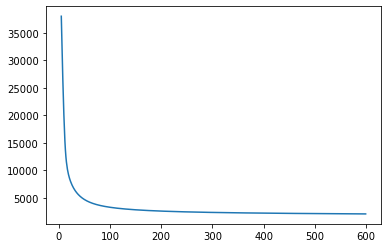

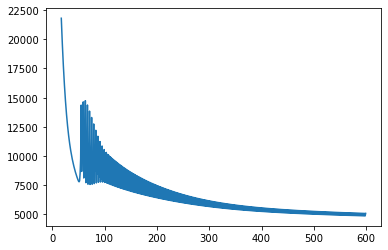

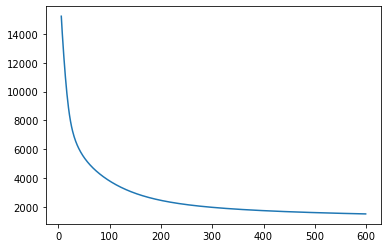

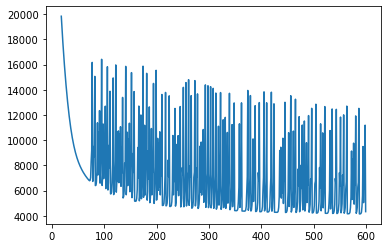

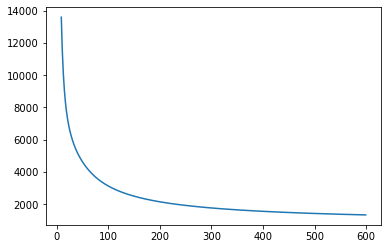

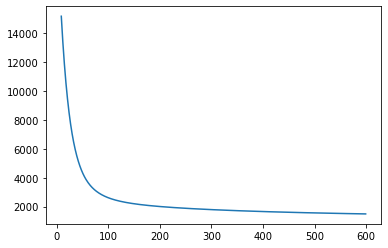

Time taken is 835.6993494033813 seconds
Accuracy result for multinomial logistic regression (raw) is: 0.7316666666666667
Number of components retained is: 144


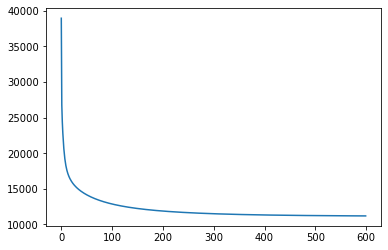

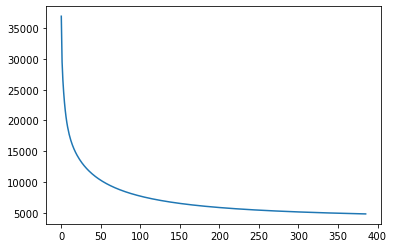

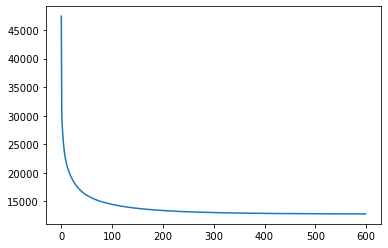

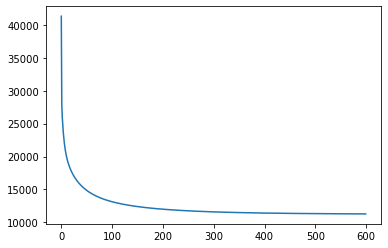

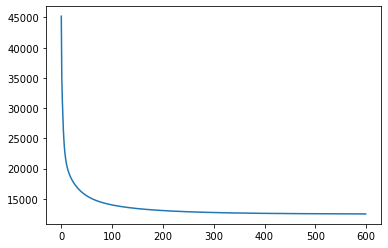

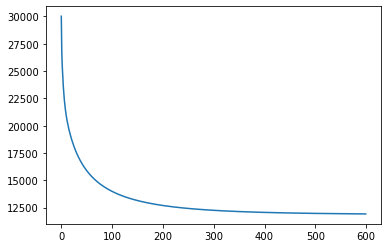

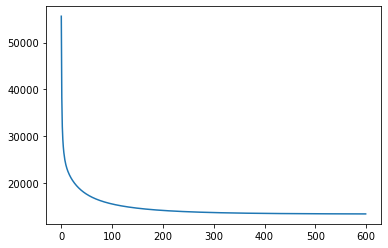

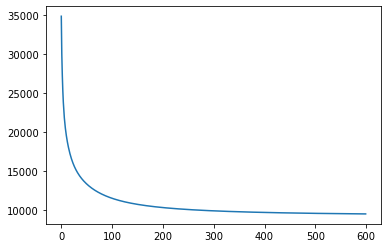

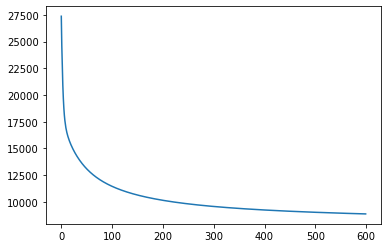

Time taken is 150.80529379844666 seconds
Accuracy result for multinomial logistic regression (PCA) is: 0.7071111111111111


In [101]:
split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)

LEARNING_RATE = 0.47
LAMBDA = 0
MAX_ITER = 600

start = time.time()
predictions = multiclass_logistic_regression(split_data_train, split_label_train, split_data_validation, LEARNING_RATE, LAMBDA, MAX_ITER, plot_it=True)
end = time.time()
print(f"Time taken is {end-start} seconds")

accuracy = calc_top1_accuracy(predictions, split_label_validation)
print(f"Accuracy result for multinomial logistic regression (raw) is: {accuracy}")

start = time.time()
pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components='dynamic')
predictions = multiclass_logistic_regression(pca_data_train, split_label_train, pca_data_test, LEARNING_RATE, LAMBDA, MAX_ITER, plot_it=True)
end = time.time()
print(f"Time taken is {end-start} seconds")

accuracy = calc_top1_accuracy(predictions, split_label_validation)
print(f"Accuracy result for multinomial logistic regression (PCA) is: {accuracy}")

We then look for the best value of our regularisation term LAMBDA

In [94]:
# Finding the best value of LAMBDA

LEARNING_RATE = 0.47
MAX_ITER = 600
N_RUNS = 1

for LAMBDA in range(1,16, 1):
    accuracy_results = []
    for _ in range(N_RUNS):
        # do the shuffle and train/validation split
        split_data_train, split_label_train, split_data_validation, split_label_validation = train_validation_split(0.7, data_train, label_train)
        
        pca_data_train, pca_data_test = apply_pca(split_data_train, split_data_validation, n_components='dynamic')
        pca_mlr_results = multiclass_logistic_regression(pca_data_train, split_label_train, pca_data_test, LEARNING_RATE, LAMBDA, MAX_ITER, plot_it=False)
        accuracy = calc_top1_accuracy(pca_mlr_results, split_label_validation)
        accuracy_results.append(accuracy)
    print(f'Average accuracy result for Multinomial Logistic Regression with LAMBDA={LAMBDA} is {(sum(accuracy_results))/N_RUNS}')

Number of components retained is: 144


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Average accuracy result for Multinomial Logistic Regression with LAMBDA=1 is 0.7008888888888889
Number of components retained is: 144
Average accuracy result for Multinomial Logistic Regression with LAMBDA=2 is 0.7097777777777777
Number of components retained is: 145
Average accuracy result for Multinomial Logistic Regression with LAMBDA=3 is 0.6961111111111111
Number of components retained is: 144
Average accuracy result for Multinomial Logistic Regression with LAMBDA=4 is 0.7013333333333334
Number of components retained is: 144
Average accuracy result for Multinomial Logistic Regression with LAMBDA=5 is 0.6996666666666667
Number of components retained is: 145
Average accuracy result for Multinomial Logistic Regression with LAMBDA=6 is 0.7
Number of components retained is: 144
Average accuracy result for Multinomial Logistic Regression with LAMBDA=7 is 0.7063333333333334
Number of components retained is: 144
Average accuracy result for Multinomial Logistic Regression with LAMBDA=8 is 

In [95]:
LEARNING_RATE = 0.47
MAX_ITER = 600
LAMBDA = 2

start = time.time()
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components='dynamic')
pca_mlr_results = multiclass_logistic_regression(pca_data_train, label_train, pca_data_test, LEARNING_RATE, LAMBDA, MAX_ITER, plot_it=False)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(pca_mlr_results, label_test)        
print(f"Accuracy result for NB (PCA) is: {accuracy}")
print()

Number of components retained is: 145


c:\users\jsnar\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


Time taken is 233.13877892494202 seconds
Accuracy result for NB (PCA) is: 0.701



### Output of Best Classifier

In [96]:
start = time.time()
pca_data_train, pca_data_test = apply_pca(data_train, data_test, n_components='dynamic')
knn_pca_results = knn(pca_data_train, label_train, pca_data_test, K=7)
end = time.time()
print(f"Time taken is {end-start} seconds")
accuracy = calc_top1_accuracy(knn_pca_results, label_test)
print(f"Accuracy result for kNN (PCA) is: {accuracy}")

output_prediction(knn_pca_results)

Number of components retained is: 145
Time taken is 113.57551193237305 seconds
Accuracy result for kNN (PCA) is: 0.8365


In [98]:
# Test loading our output predictions
with h5py.File('./Output/predicted_labels.h5','r') as H:
    predictions = np.copy(H['Output'])
    
predictions.shape

(5000,)